This is an outline for building a neural network classifier using Tensorflow. I will likely be using the same code for a lot of the processing of the larger data set. Feel free to use what you see here to build your own models.

In [3]:
# Read in data

import pandas as pd

df = pd.read_csv("../data/subjectInfoChallenge.csv", delimiter=",")

subj_id = df.loc[:, 'Subject-Id']  # Useless column for our purposes
df = df.drop(columns='Subject-Id')
print(df)

      Group  Age          Sex    Handedness  MADRS  YMRS  Suicide-Attempts  \
0   Control   47       Female         Right      4     2                 0   
1   Bipolar   28         Male  Ambidextrous      7    19                 0   
2   Control   58       Female         Right      1     0                 0   
3   Bipolar   29       Female         Right     11     7                30   
4   Bipolar   57       Female         Right     25     0                 0   
..      ...  ...          ...           ...    ...   ...               ...   
86  Bipolar   28         Male         Right     30     2                 5   
87  Bipolar   21  Transgender         Right     25     4                 0   
88  Bipolar   37         Male         Right     23    19                 0   
89  Control   28       Female         Right      5     1                 0   
90  Bipolar   55       Female         Right      8     4                 1   

    Anat-Exists  Func-Exists  DWI-Exists  
0             1     

In [4]:
# One-hot encoding  -- used to convert categorical data into numerical values

def encode(df, dictionary, column):
    encoded = [dictionary[val] for val in df.loc[:, column]]
    df = df.drop(columns=column)
    return encoded, df

conv_y = {"Bipolar": [1,0], "Control": [0,1]}  # probably easier to use a single value here, see note at end
y, df = encode(df, conv_y, "Group")

conv_sex = {"Female": [1,0, 0], "Male": [0,1, 0], "Transgender": [0,0,1]}
sex, df = encode(df, conv_sex, "Sex")

conv_handedness = {"Left": [1,0, 0], "Right": [0,1, 0], "Ambidextrous": [0,0,1]}
handedness, df = encode(df, conv_handedness, "Handedness")


print(y, '\n', sex, '\n', handedness)

[[0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0]] 
 [[1, 0, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [1, 

In [5]:
# Example numerical only dataframe

print(df)

    Age  MADRS  YMRS  Suicide-Attempts  Anat-Exists  Func-Exists  DWI-Exists
0    47      4     2                 0            1            1           1
1    28      7    19                 0            1            1           1
2    58      1     0                 0            1            1           1
3    29     11     7                30            1            1           1
4    57     25     0                 0            1            1           1
..  ...    ...   ...               ...          ...          ...         ...
86   28     30     2                 5            1            1           1
87   21     25     4                 0            1            1           1
88   37     23    19                 0            1            1           1
89   28      5     1                 0            1            1           1
90   55      8     4                 1            1            1           1

[91 rows x 7 columns]


In [22]:
# Convert categorical values to numpy array

import numpy as np

target_vals = np.array(y)
sex_and_handedness = np.concatenate((np.array(sex), np.array(handedness)), axis=1)
print(sex_and_handedness.shape)  # check to make sure all 91 rows are present

'''
Get rid of other non-info columns (might potentially contain info for the model but the
goal of this exercise is to also undertand data quality) 
'''
df = df.drop(columns=['Anat-Exists', 'Func-Exists', 'DWI-Exists'])
training_array = np.concatenate((df.values, sex_and_handedness), axis=1)

(91, 6)


In [40]:
''' 
Split the data into testing and training sets
&
Rescale numerical data so its normalized between -1 and 1 -- this allows the
NN to converge quicker
'''

print(training_array[:10], '\n', target_vals[:10])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(training_array, target_vals,
                                                    test_size=0.2, random_state=7)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  ## ONLY fit the scaler to the training data, testing data should always be unknown to everything in the pipeline

[[47  4  2  0  1  0  0  0  1  0]
 [28  7 19  0  0  1  0  0  0  1]
 [58  1  0  0  1  0  0  0  1  0]
 [29 11  7 30  1  0  0  0  1  0]
 [57 25  0  0  1  0  0  0  1  0]
 [44 15 10  2  1  0  0  0  1  0]
 [47 14  8  1  1  0  0  0  1  0]
 [56  0  1  0  0  1  0  0  1  0]
 [22  2  0  0  0  1  0  0  1  0]
 [27  0  1  0  0  1  0  1  0  0]] 
 [[0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


In [175]:
# Show scaled values -- only x was scaled because y values are already in range [-1,1]

print(X_train[:10], '\n', y_train[:10])

l = [1 for val in y_train if np.array_equal(val, np.array([1,0]))]

print('Percent of Bipolar positive in training data', sum(l)/len(y_train))
# Note if the percent of any given class is too high it can cause issues with the model

[[0.5        0.875      0.68       0.03333333 1.         0.
  0.         0.         1.         0.        ]
 [0.30434783 0.125      0.16       0.         0.         1.
  0.         0.         1.         0.        ]
 [0.56521739 0.46875    0.4        0.06666667 1.         0.
  0.         0.         1.         0.        ]
 [0.19565217 0.09375    0.         0.         1.         0.
  0.         0.         1.         0.        ]
 [0.41304348 0.71875    0.76       0.         0.         1.
  0.         0.         1.         0.        ]
 [0.17391304 0.25       0.         0.03333333 0.         1.
  0.         0.         1.         0.        ]
 [0.80434783 0.25       0.16       0.03333333 1.         0.
  0.         0.         1.         0.        ]
 [0.10869565 0.21875    0.16       0.         0.         1.
  0.         0.         1.         0.        ]
 [1.         0.09375    0.04       0.03333333 0.         1.
  0.         0.         1.         0.        ]
 [0.06521739 0.78125    0.16       0.

In [176]:
# Build a simple MLP model using keras

from tensorflow import keras


keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('softmax'))

model.summary()

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0

In [161]:
# Fit the model and check it against the test set

model_fit = model.fit(X_train, y_train, epochs=100, validation_split=0.2)
pred = model.predict(X_test)
print(pred)  # check to make sure the model isn't predicting the same class every time

Train on 57 samples, validate on 15 samples
Epoch 1/100
57/57 [==============================] - 1s 19ms/sample - loss: 0.2235 - accuracy: 0.6667 - val_loss: 0.2306 - val_accuracy: 0.6000
Epoch 2/100
57/57 [==============================] - 0s 516us/sample - loss: 0.2077 - accuracy: 0.6842 - val_loss: 0.2273 - val_accuracy: 0.6000
Epoch 3/100
57/57 [==============================] - 0s 531us/sample - loss: 0.2163 - accuracy: 0.7193 - val_loss: 0.2300 - val_accuracy: 0.6000
Epoch 4/100
57/57 [==============================] - 0s 705us/sample - loss: 0.2198 - accuracy: 0.7018 - val_loss: 0.2320 - val_accuracy: 0.6000
Epoch 5/100
57/57 [==============================] - 0s 730us/sample - loss: 0.1839 - accuracy: 0.7193 - val_loss: 0.2329 - val_accuracy: 0.6000
Epoch 6/100
57/57 [==============================] - 0s 735us/sample - loss: 0.2076 - accuracy: 0.7193 - val_loss: 0.2314 - val_accuracy: 0.6000
Epoch 7/100
57/57 [==============================] - 0s 597us/sample - loss: 0.2003 - a

Epoch 57/100
57/57 [==============================] - 0s 580us/sample - loss: 0.0835 - accuracy: 0.8772 - val_loss: 0.1453 - val_accuracy: 0.8000
Epoch 58/100
57/57 [==============================] - 0s 570us/sample - loss: 0.0834 - accuracy: 0.9298 - val_loss: 0.1443 - val_accuracy: 0.8000
Epoch 59/100
57/57 [==============================] - 0s 559us/sample - loss: 0.0886 - accuracy: 0.8772 - val_loss: 0.1435 - val_accuracy: 0.8000
Epoch 60/100
57/57 [==============================] - 0s 640us/sample - loss: 0.1060 - accuracy: 0.8421 - val_loss: 0.1433 - val_accuracy: 0.8000
Epoch 61/100
57/57 [==============================] - 0s 720us/sample - loss: 0.0901 - accuracy: 0.8947 - val_loss: 0.1404 - val_accuracy: 0.8000
Epoch 62/100
57/57 [==============================] - 0s 992us/sample - loss: 0.0817 - accuracy: 0.8947 - val_loss: 0.1412 - val_accuracy: 0.8000
Epoch 63/100
57/57 [==============================] - 0s 1ms/sample - loss: 0.0890 - accuracy: 0.8772 - val_loss: 0.1457 - v

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0, 0.5, 'Accuracy')

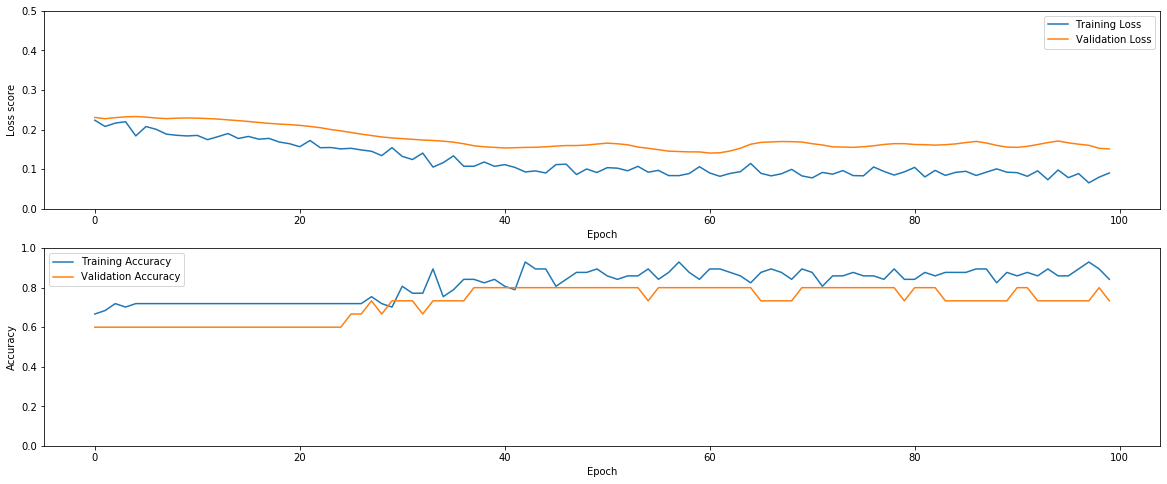

In [179]:
# Check model loss and accuracy

print(model_fit.history.keys())
hist = model_fit.history

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
fig.patch.set_facecolor('white')

ax.plot(hist['loss'], label='Training Loss')
ax.plot(hist['val_loss'], label='Validation Loss')
ax.legend()
ax.set_ylim(0, .5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss score')

ax1.plot(hist['accuracy'], label='Training Accuracy')
ax1.plot(hist['val_accuracy'], label='Validation Accuracy')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

In [170]:
pred_outcomes = [item[0] > item[1] for item in pred]
actual_outcomes = [item[0] > item[1] for item in y_test]
correct = [item[0] == item[1] for item in zip(pred_outcomes, actual_outcomes)]
print('accuracy on test set:', sum(correct)/len(correct))

accuracy on test set: 0.7894736842105263


The loss curve shows that the validation loss was slightly higher than the training loss which indicates that the model was overtrained a bit, but not by much since the accuracy for the training/validation sets was similar to the accuracy on the test set. Ways to improve this model would be to have more data (or to upsample bipolar negative cases since about 70% of the training set was bipolar positive cases, so the model had a slight bias towards picking positive), and increase dropout layers for generalizability (but not overdo it becuase it can impact the model negatively). AUC can also be calculated but it is a little harder to do since this model was designed to predict values for two classes. NOTE to self: the model for the big dataset should just output one value so it is easy to calculate AUC.